Note: Training set in ssd much faster

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

import warnings
warnings.filterwarnings("ignore")

DIR = 'C:/Human Protein'

In [2]:
sample_submission = pd.read_csv(DIR+"./input/sample_submission.csv")

print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (11702, 2)


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [3]:
train = pd.read_csv(DIR+"./input/train.csv")

print('train.shape:', train.shape)
train.head()

train.shape: (31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


# Get Train, Test Dataset

In [4]:
def getTrainDataset():
    
    path_to_train = DIR+'./input/train_images/'
    data = pd.read_csv(DIR+'./input/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        labels.append(y)
        
        paths.append(os.path.join(path_to_train, name))

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR+'./input/test_images/'
    data = pd.read_csv(DIR+'./input/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        labels.append(y)
        paths.append(os.path.join(path_to_test, name))

    return np.array(paths), np.array(labels)

## Display Test Dataset

In [5]:
paths, labels = getTestDataset()

In [6]:
print('paths.shape:', paths.shape)
paths

paths.shape: (11702,)


array(['C:/Human Protein./input/test_images/00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
       'C:/Human Protein./input/test_images/0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
       'C:/Human Protein./input/test_images/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
       ...,
       'C:/Human Protein./input/test_images/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0',
       'C:/Human Protein./input/test_images/fff03816-bad5-11e8-b2b9-ac1f6b6435d0',
       'C:/Human Protein./input/test_images/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0'],
      dtype='<U72')

In [7]:
print('labels.shape:', labels.shape)
labels

labels.shape: (11702, 28)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Display Train Dataset

In [8]:
paths, labels = getTrainDataset()

In [9]:
print('paths.shape:', paths.shape)
paths

paths.shape: (31072,)


array(['C:/Human Protein./input/train_images/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
       'C:/Human Protein./input/train_images/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       'C:/Human Protein./input/train_images/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       ...,
       'C:/Human Protein./input/train_images/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0',
       'C:/Human Protein./input/train_images/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0',
       'C:/Human Protein./input/train_images/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0'],
      dtype='<U73')

In [10]:
print('labels.shape:', labels.shape)
labels

labels.shape: (31072, 28)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

# Split into train, val set

## Split train.index into train_index, val_index

In [11]:
VALIDATION_SPLIT = 0.09
SEED = 777

In [12]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(
    train.index, test_size=VALIDATION_SPLIT, random_state=SEED)

print('train_index.shape:', train_index.shape)
print('val_index.shape:', val_index.shape)

train_index.shape: (28275,)
val_index.shape: (2797,)


## Split paths, label into paths_train, labels_train, paths_val, labels_val

In [13]:
paths_train = paths[train_index]
labels_train = labels[train_index]
paths_val = paths[val_index]
labels_val = labels[val_index]

print('paths.shape:', paths.shape)
print('labels.shape:', labels.shape)
print()
print('paths_train.shape:', paths_train.shape)
print('labels_train.shape:', labels_train.shape)
print('paths_val.shape:', paths_val.shape)
print('labels_val.shape:', labels_val.shape)

paths.shape: (31072,)
labels.shape: (31072, 28)

paths_train.shape: (28275,)
labels_train.shape: (28275, 28)
paths_val.shape: (2797,)
labels_val.shape: (2797, 28)


# Data Generator

In [14]:
import keras

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),                                                            # horizontal flips
                    iaa.Crop(percent=(0, 0.1)),                                                 # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),   #cannot float64 (1./255)
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    #iaa.Multiply((0.8, 1.2), per_channel=0.2),                                  #cannot float64 (1./255)
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = np.array(Image.open(path + '_red.png'))
        G = np.array(Image.open(path + '_green.png'))
        B = np.array(Image.open(path + '_blue.png'))
        Y = np.array(Image.open(path + '_yellow.png'))

        # (256,256,4)
        im = np.stack((
            R, 
            G, 
            B,
            Y), -1)
        
#         # (256,256,3)
#         im = np.stack((
#             R/2 + Y/2, 
#             G/2 + Y/2, 
#             B),-1)
        
        im = cv2.resize(im, (self.shape[0], self.shape[1]))
        im = np.divide(im, 255)
        return im

Using TensorFlow backend.


In [15]:
BATCH_SIZE = 32
INPUT_SHAPE = (256, 256, 4)

In [16]:
train_datagen = ProteinDataGenerator(
    paths  = paths_train, 
    labels = labels_train, 
    batch_size = BATCH_SIZE, 
    shape = INPUT_SHAPE, 
    use_cache = False,
    augment = False, 
    shuffle = True)

val_datagen = ProteinDataGenerator(
    paths  = paths_val, 
    labels = labels_val, 
    batch_size = BATCH_SIZE, 
    shape = INPUT_SHAPE, 
    use_cache = False, 
    shuffle = False)

print('steps_per_epoch:', len(train_datagen))
print('validation_steps:', len(val_datagen))

steps_per_epoch: 884
validation_steps: 88


# Model in Keras

In [17]:
import keras
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [18]:
# Metric: F1

def f1(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [19]:
KEEP_PROB = 0.25

In [20]:
def create_model(input_shape):
    
    inputs = Input(input_shape)
    
    x = Conv2D(8, (3, 3))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(8, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(16, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(KEEP_PROB)(x)
    
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(KEEP_PROB)(x)
    
    x = Conv2D(32, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(KEEP_PROB)(x)
    
    x = Conv2D(64, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(KEEP_PROB)(x)
    
    x = Conv2D(128, (3, 3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(KEEP_PROB)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    #x = Flatten()(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(28, activation = 'sigmoid')(x)
    
    model = Model(inputs, outputs)

    model.summary()
    
    return model

In [22]:
%%time

keras.backend.clear_session()

# Create model
model = create_model(input_shape = INPUT_SHAPE)

# Load weights
model.load_weights('./model/protein_CNN_valloss_0.0962.h5')

# Compile model
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr=1e-03),
    metrics = ['acc',f1])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 254, 254, 8)  296         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 254, 254, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 254, 254, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Wall time: 1.6 s


In [23]:
# Define callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ModelCheckpoint: Save the (best) model weights after every epoch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
             EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/protein_CNN_valloss.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False)
            ]

In [23]:
EPOCHS = 10

In [61]:
%%time
# Train the model

history = model.fit_generator(
                train_datagen,
                #steps_per_epoch = len(train_datagen),
                epochs = EPOCHS,
                validation_data = val_datagen,
                #validation_steps = len(val_datagen),
                callbacks = callbacks,
                workers=3,
                max_queue_size=10,
                )

Epoch 1/1


ValueError: Got dtype 'float64' in augmenter 'UnnamedAdditiveGaussianNoise' (class 'AddElementwise'), which is a forbidden dtype (uint32, uint64, uint128, uint256, int32, int64, int128, int256, float64, float96, float128, float256).

In [ ]:
# Save model
model.save('./model/protein_CNN_valloss.h5')

In [26]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_f1', 'loss', 'acc', 'f1', 'lr'])


# Model Evaluation

## 1) Plot learning rate, loss, f1, acc

In [113]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('learning rate')
    ax[0].plot(history.epoch, history.history["lr"], label="lr")
    #ax[0].xlabel('Epoch')
    #ax[0].ylabel('Learning Rate')

    ax[1].set_title('loss')
    ax[1].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[1].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[2].set_title('f1')
    ax[2].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[2].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    
    ax[3].set_title('acc')
    ax[3].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[3].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

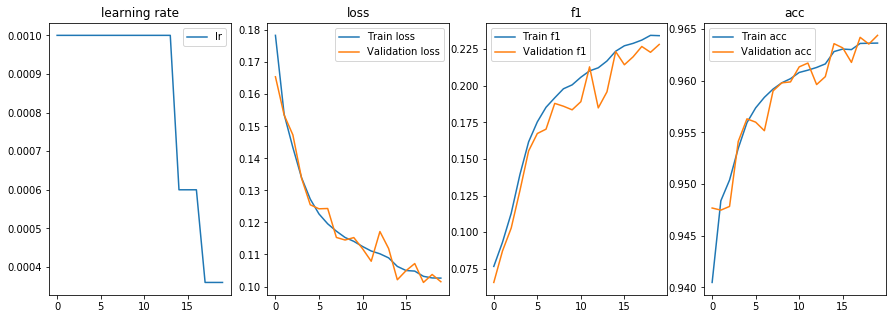

In [28]:
show_history(history)

## 2) Loss and dice_coef (val)

In [22]:
%%time

# val_datagen.reset()
# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(val_datagen, 
                                 #steps = validation_steps
                                )
print("loss:", score[0])
print("metric (acc):", score[1])
print("metric (f1):", score[2])

loss: 0.09621999661305311
metric (acc): 0.9662904177429764
metric (f1): 0.24671557249982826
Wall time: 36.8 s


## 3) Confusion Matrix

In [24]:
%%time

# validation_generator.reset()
# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(val_datagen, 
                                          #steps = validation_steps
                                         )

Wall time: 37.2 s


In [25]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

y_val_pred_prob.shape: (2797, 28)


array([[1.6581267e-02, 4.8819184e-04, 6.1422586e-04, ..., 1.3841271e-02,
        2.2217631e-04, 2.9802322e-04],
       [5.7484329e-01, 3.7809312e-03, 5.7569891e-02, ..., 2.8030449e-01,
        4.0609121e-02, 8.1360340e-05],
       [4.2396417e-01, 8.8948011e-04, 6.7025721e-03, ..., 8.2361460e-02,
        1.3199598e-02, 3.4302473e-04],
       ...,
       [2.0655990e-02, 1.8456578e-04, 8.9472532e-04, ..., 6.7192912e-03,
        2.6375055e-05, 1.4793873e-04],
       [2.3418322e-01, 7.5241327e-03, 9.1674924e-02, ..., 1.7903161e-01,
        8.8711590e-02, 3.3754110e-04],
       [3.6439750e-01, 1.4543533e-05, 1.8155575e-04, ..., 3.1420588e-04,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [26]:
y_val_pred = (y_val_pred_prob > 0.5).astype(np.uint8)
y_val_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [71]:
import itertools
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, labels):
    instcount = y_true.shape[0]
    n_classes = len(labels)
    fp = ((y_true - y_pred) < 0).sum(axis = 0)
    fn = ((y_true - y_pred) > 0).sum(axis = 0)
    tp = (y_true*y_pred).sum(axis = 0)
    tn = ((y_true==0)*(y_pred==0)).sum(axis = 0)
    mtx = np.vstack([tp/(tp + fn), fn/(tp + fn), tn/(tn + fp), fp/(tn + fp)]).T
    plt.figure(num=None, figsize=(5, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtx, interpolation='nearest',cmap='Blues')
    plt.title("Confusion matrix")
    tick_marks = np.arange(n_classes)
    plt.xticks(np.arange(4), ['1 - 1','1 - 0','0 - 0','0 - 1'])
    plt.yticks(tick_marks, labels)
    for i, j in itertools.product(range(n_classes), range(4)):
        plt.text(j, i, round(mtx[i][j],2), horizontalalignment="center")

    plt.ylabel('labels')
    plt.xlabel('True-Predicted')
    plt.show()

In [72]:
labels  = ['0','1','2','3','4','5','6','7','8','9',
           '10','11','12','13','14','15','16','17','18','19',
           '20','21','22','23','24','25','26','27']

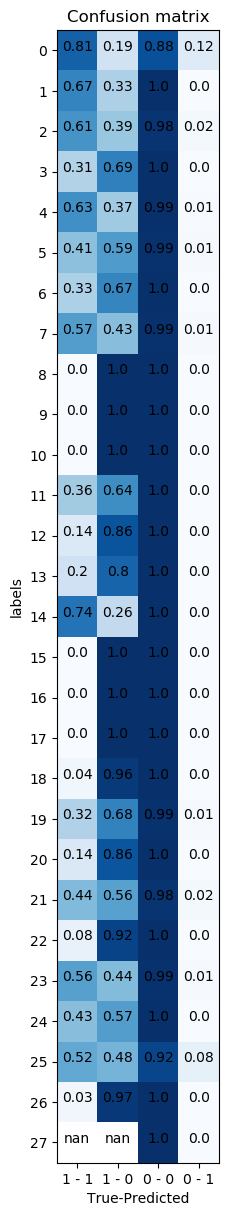

In [73]:
confusion_matrix(labels_val, y_val_pred, labels)

## 4) Miss-Classification table

In [84]:
def miss_classification(y_true, y_pred, classes, percent=False, multi_label=True):
    '''
    Params:
        y_true, y_pred : binary numpy array
        classes : list of names classes
        percent : display persent of miss classification
        multi_label : target can have multy labels
    '''

    n_classes = len(classes)
    fp = ((y_true - y_pred) < 0).astype('int')
    fn = ((y_true - y_pred) > 0).astype('int')
    mtc = (fn.T @ fp)
    if multi_label:
        mtc = np.hstack([mtc, (fp.sum(axis = 0) - mtc.sum(axis = 0)).clip(0)[:,None]])
        classes.append('As extra class')
    if percent:
        mtc = (mtc / mtc.sum(axis = 1)[:,None])
        mtc = np.nan_to_num(mtc).clip(0,1) * 100
        
    plt.figure(num=None, figsize=(10.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtc, interpolation='nearest',cmap='Blues')
    plt.title("Miss-Classification table")

    plt.xticks(np.arange(mtc.shape[1]), classes, rotation=90)
    plt.yticks(np.arange(mtc.shape[0]), classes, rotation=0)
    
    for i in range(mtc.shape[0]):
        for j in range(mtc.shape[1]):
            plt.text(j, i, int(mtc[i][j]), horizontalalignment="center")
    plt.ylabel('True labels')
    plt.xlabel('Predicted Miss labeled')
    plt.show()

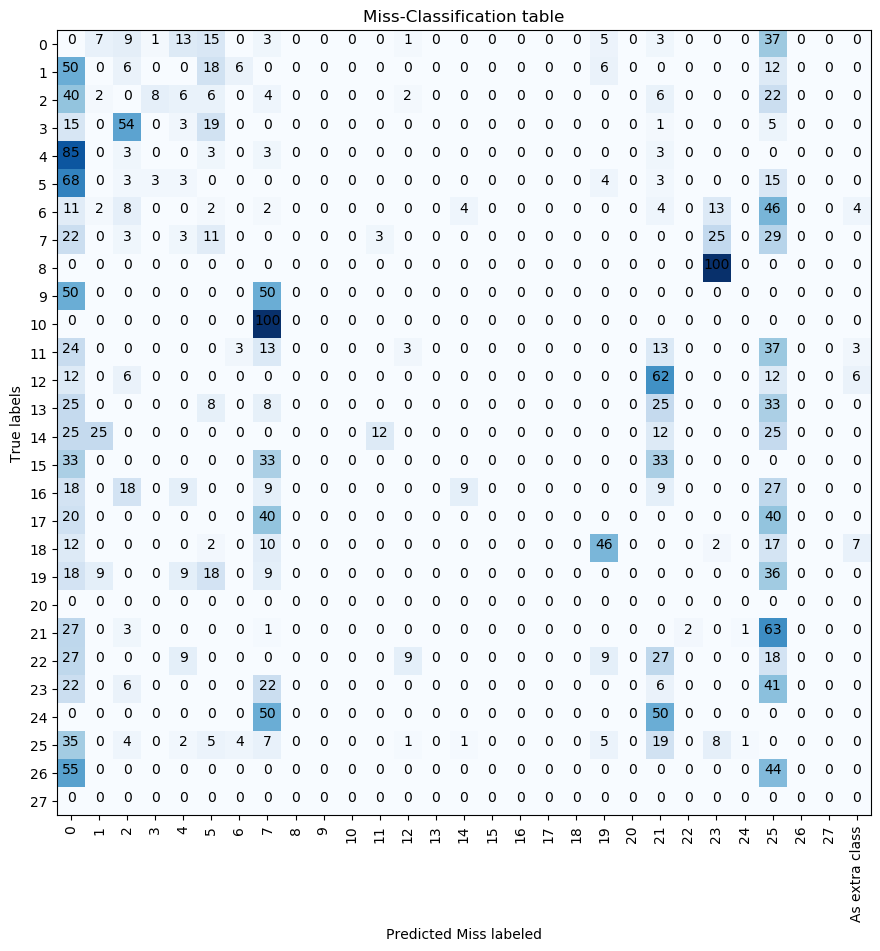

In [85]:
miss_classification(labels_val, y_val_pred, labels, percent=True)

# Prediction

## Test Data Generator

In [91]:
# Get test dataset
paths_test, labels_test = getTestDataset()
print('paths_test.shape:', paths_test.shape)
print('labels_test.shape:', labels_test.shape)

paths_test.shape: (11702,)
labels_test.shape: (11702, 28)


In [92]:
# Create test data generator
test_datagen = ProteinDataGenerator(
    paths  = paths_test, 
    labels = labels_test, 
    batch_size = BATCH_SIZE, 
    shape = INPUT_SHAPE, 
    use_cache = False, 
    shuffle = False)
print('test_steps:', len(test_datagen))

test_steps: 366


In [88]:
%%time

# test_datagen.reset()
y_test_pred_prob = model.predict_generator(test_datagen,
                                           #steps = test_steps
                                          )

Wall time: 3min 16s


In [89]:
print('y_test_pred_prob.shape:', y_test_pred_prob.shape)
y_test_pred_prob

y_test_pred_prob.shape: (11702, 28)


array([[4.7791988e-02, 8.0725551e-04, 9.9065471e-01, ..., 2.3455620e-02,
        1.0240972e-03, 2.9802322e-08],
       [5.3985029e-02, 1.3032794e-02, 1.0342598e-02, ..., 2.4962270e-01,
        2.3871452e-02, 3.9830804e-04],
       [9.2809737e-01, 7.0786476e-04, 7.6890886e-03, ..., 7.7509648e-01,
        3.5166144e-03, 2.7716160e-06],
       ...,
       [1.3365093e-01, 5.6633353e-03, 5.8998764e-03, ..., 1.5454674e-01,
        4.5829266e-02, 6.4182281e-04],
       [1.3622925e-01, 9.5943511e-01, 2.0140618e-02, ..., 7.5668126e-02,
        8.6678565e-03, 7.4505806e-06],
       [6.9995236e-01, 2.3684502e-03, 6.8182230e-02, ..., 6.7337066e-01,
        6.9857836e-03, 3.9041042e-06]], dtype=float32)

In [90]:
y_test_pred = (y_test_pred_prob > 0.5).astype(np.uint8)
y_test_pred

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]], dtype=uint8)

# Submission

In [86]:
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (11702, 2)


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [98]:
y_test_pred.shape

(11702, 28)

In [99]:
prediction = []

for row in range(sample_submission.shape[0]):
    
    str_label = ''
    
    for col in range(y_test_pred.shape[1]):
        if(y_test_pred[row, col] == 1):
            str_label += str(col) + ' '

    prediction.append(str_label.strip())

prediction = np.array(prediction)

In [103]:
print('prediction.shape:', prediction.shape)
prediction

prediction.shape: (11702,)


array(['2', '5', '0 25', ..., '', '1', '0 25'], dtype='<U9')

In [106]:
sample_submission['Predicted'] = prediction
sample_submission.to_csv('./output/submission_protein.csv', index=False)

# Plot Model png

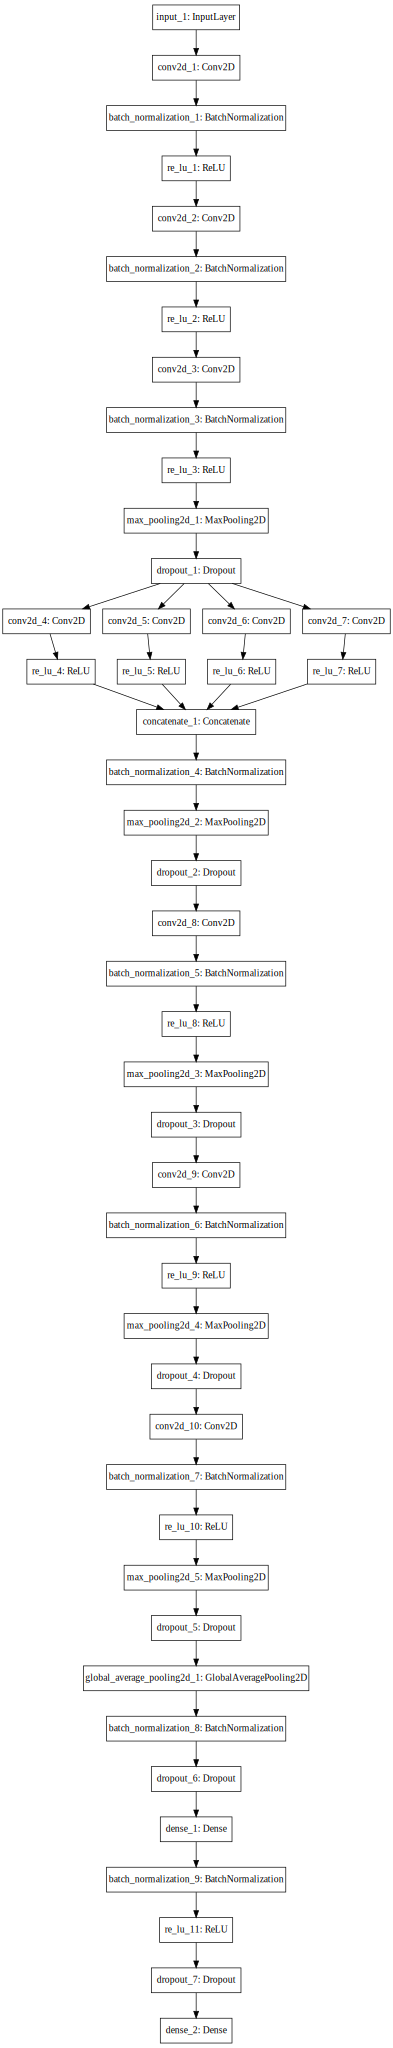

In [105]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='./model/model_cnn_protein.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))